In [1]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import segmentation_models_pytorch as smp
from torchviz import make_dot
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import plotly.graph_objects as go
from IPython.display import display, clear_output
import plotly.express as px
import holocron
import pandas as pd
import random
from models import *
import monai
%matplotlib inline

In [2]:
class newDataset(Dataset):
    def __init__(self, image_files, mask_files, input_size=(512,512), transform=None):
        self.image_files=image_files
        self.mask_files=mask_files
        self.input_size=input_size
        self.transform=transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path=self.image_files[idx]
        mask_path=self.mask_files[idx]  

        image = cv2.imread(image_path, 0)
        mask = cv2.imread(mask_path, 0)  

        image = self.image_histogram_equalization(image.astype('float32')/image.max())
        mask = mask.astype('float32')/255.

        image=torch.tensor(image)
        mask=torch.tensor(mask)

        if self.transform:
            image,mask=self.augment_image(image,mask)
        
        return image, mask
    
    def image_histogram_equalization(self, image, number_bins=256):
        image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
        cdf = image_histogram.cumsum() 
        cdf = (number_bins-1) * cdf / cdf[-1] 
        
        image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    
        return image_equalized.reshape(image.shape)
    
    def augment_image(self, image, mask):
        shape = (*image.shape, 1 )
        image_np = image.reshape(shape).numpy()
        mask_np = mask.reshape(shape).numpy()
        augmented = self.transform(image = image_np,mask = mask_np)
        augmented_image , augmented_mask = augmented['image'],augmented['mask']
        augmented_image = augmented_image.reshape(augmented_image.shape[:-1])
        augmented_mask = augmented_mask.reshape(augmented_mask.shape[:-1])
        augmented_image = torch.tensor(augmented_image, dtype=torch.float32)
        augmented_mask  = torch.tensor(augmented_mask,dtype=torch.float32)
        
        return augmented_image,augmented_mask
    
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.epochs_no_improve = 0
        self.should_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.should_stop = True

class SegmentationPerformance:
    def __init__(self, num_samples=5, device='cuda'):
        self.metrics_sum = {'Precision': 0, 'Recall': 0, 'Accuracy': 0, 'Dice Coefficient': 0, 'IoU': 0}
        self.count = 0
        self.total_loss = 0.0
        self.saved_samples = []
        self.num_samples = num_samples
        self.device = device

    def precision_score_(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        total_pixel_pred = torch.sum(pred_mask)
        precision = intersect.float() / total_pixel_pred.float() if total_pixel_pred != 0 else torch.tensor(0.0, device=groundtruth_mask.device)
        return precision.item()

    def recall_score_(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        total_pixel_truth = torch.sum(groundtruth_mask)
        recall = intersect.float() / total_pixel_truth.float() if total_pixel_truth != 0 else torch.tensor(0.0, device=groundtruth_mask.device)
        return recall.item()

    def accuracy(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
        xor = torch.sum(groundtruth_mask == pred_mask)
        acc = xor.float() / (union + xor - intersect).float() if (union + xor - intersect) != 0 else torch.tensor(0.0, device=self.device)
        return acc.item()

    def dice_coef(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        total_sum = torch.sum(pred_mask) + torch.sum(groundtruth_mask)
        dice = (2 * intersect).float() / total_sum.float() if total_sum != 0 else torch.tensor(0.0, device=self.device)
        return dice.item()

    def iou(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
        iou = intersect.float() / union.float() if union != 0 else torch.tensor(0.0, device=self.device)
        return iou.item()

    def update_metrics_and_save_sample(self, groundtruth_mask, pred_mask, loss=None, image=None, gt_mask=None, pred_mask_sample=None):
        self.metrics_sum['Precision'] += self.precision_score_(groundtruth_mask, pred_mask)
        self.metrics_sum['Recall'] += self.recall_score_(groundtruth_mask, pred_mask)
        self.metrics_sum['Accuracy'] += self.accuracy(groundtruth_mask, pred_mask)
        self.metrics_sum['Dice Coefficient'] += self.dice_coef(groundtruth_mask, pred_mask)
        self.metrics_sum['IoU'] += self.iou(groundtruth_mask, pred_mask)
        if loss is not None:
            self.total_loss += loss.item()

        if image is not None:
            # Convert to CPU for plotting
            self.saved_samples.append((image.cpu().numpy(), gt_mask.cpu().numpy(), pred_mask_sample.cpu().numpy()))

        self.count += 1

    def get_average_metrics(self):
        average_metrics = {metric: value / self.count for metric, value in self.metrics_sum.items()}
        average_metrics['Average Loss'] = self.total_loss / self.count if self.count != 0 else 0
        return average_metrics

    def report(self):
        metrics = self.get_average_metrics()
        return pd.DataFrame([metrics])
    
    def plot_saved_samples(self, figsize=(15, 15)):
        if not self.saved_samples:
            print("No samples saved for plotting.")
            return

        plt.figure(figsize=figsize)

        for i, (image, groundtruth_mask, predicted_mask) in enumerate(self.saved_samples):
            if image.ndim == 3:
                if image.shape[0] == 3:  
                    image = image.transpose(1, 2, 0)
                elif image.shape[0] == 1:  
                    image = image.squeeze(0)  #

            image = (image - image.min()) / (image.max() - image.min()) if image.max() != image.min() else image

            plt.subplot(self.num_samples, 3, i * 3 + 1)
            plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
            plt.title('Image')
            plt.axis('off')

            plt.subplot(self.num_samples, 3, i * 3 + 2)
            plt.imshow(groundtruth_mask.squeeze(), cmap='gray')
            plt.title('Ground Truth Mask')
            plt.axis('off')

            plt.subplot(self.num_samples, 3, i * 3 + 3)
            plt.imshow(predicted_mask.squeeze(), cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [3]:
base_path = "C:\\Users\\Bartek\\Desktop\\mgr\\train"
dataset = "kidney_1_dense"

images_path = os.path.join(base_path,dataset,"images")
label_path = os.path.join(base_path,dataset,"labels")

image_files= sorted([os.path.join(images_path,f) for f in os.listdir(images_path) if f.endswith('.tif')])
labels_files= sorted([os.path.join(label_path,f) for f in os.listdir(label_path) if f.endswith('.tif')])

In [4]:
train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    image_files, labels_files, test_size=0.1, random_state=42)

train_image_files[:5]

['C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\0464.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\1486.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\0290.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\1581.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\1994.tif']

In [5]:
transform = A.Compose([
    A.Resize(512, 512, interpolation=cv2.INTER_NEAREST),
])

val_dataset = newDataset(val_image_files, val_mask_files, transform=transform)

In [6]:
#train_dataloader= DataLoader(train_dataset,batch_size=6,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=2,shuffle=False)

In [7]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {}

model = smp.UnetPlusPlus(
    encoder_name='timm-resnest50d',
    encoder_weights='imagenet',
    decoder_attention_type="scse",
    in_channels=1
).to(device)

models['best_model_resnet50d_50epoch.pth'] = model

model = smp.UnetPlusPlus(
    encoder_name='dpn92',
    encoder_weights='imagenet+5k',
    decoder_attention_type="scse",
    in_channels=1
).to(device)

models['best_model_dpn92_50epoch.pth'] = model

model = smp.UnetPlusPlus(
    encoder_name='timm-regnetx_120',
    encoder_weights='imagenet',
    decoder_attention_type="scse",
    in_channels=1
).to(device)

models['best_model_regnetx120_45epoch.pth'] = model

model = smp.UnetPlusPlus(
    encoder_name='timm-res2net50_26w_8s',
    encoder_weights='imagenet',
    decoder_attention_type="scse",
    in_channels=1
).to(device)

models['best_model_res2net50_26w_8s_50epoch.pth'] = model


model = monai.networks.nets.SwinUNETR(
    img_size=(512,512), 
    in_channels=1, 
    out_channels=1, 
    use_checkpoint=True, 
    spatial_dims=2,
    depths=(4,4,6,6),
    num_heads=(4,8,16,32),
    feature_size=48,
    drop_rate=0.05,            
    attn_drop_rate=0.05

).to(device)

models['best_model_swissunetr.pth'] = model

model = monai.networks.nets.UNETR(
    img_size=512, 
    in_channels=1, 
    out_channels=1, 
    hidden_size=1024,
    feature_size=32,
    num_heads=32,
    dropout_rate=0.05,            
    spatial_dims=2

).to(device)

models['best_model_unetr.pth'] = model

In [8]:
def eval_model_perf(model, criterion, idxs):
    performance_evaluator = SegmentationPerformance()

    with torch.no_grad():
        for n,(images, masks) in enumerate(val_dataloader):  
            b, h, w, c = images.shape if len(images.shape) == 4 else (*images.shape,1)

            images = images.reshape(b,c,h,w).to(device)
            masks = masks.reshape(b,c,h,w).to(device)
            
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            pred_masks = (outputs > 0.5).float()

            if n in idxs:
                performance_evaluator.update_metrics_and_save_sample(masks, pred_masks, loss, images[0], masks[0], pred_masks[0])
            else:
                performance_evaluator.update_metrics_and_save_sample(masks, pred_masks, loss)


    
    return performance_evaluator

def plot_model_comparisons(perfs, model_names, figsize=(20, 15)):
    num_models = len(model_names)

    if not perfs:
        print("No performance data available for plotting.")
        return

    num_samples = len(perfs[0].saved_samples)
    plt.figure(figsize=figsize)

    for i in range(num_samples):
        image, ground_truth, _ = perfs[0].saved_samples[i]

        # Plot original image
        plt.subplot(num_samples, num_models + 2, i * (num_models + 2) + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title('Original Image', fontsize=10)
        plt.axis('off')

        # Plot ground truth mask
        plt.subplot(num_samples, num_models + 2, i * (num_models + 2) + 2)
        plt.imshow(ground_truth.squeeze(), cmap='gray')
        plt.title('Ground Truth', fontsize=10)
        plt.axis('off')

        # Plot predictions from each model
        for j, perf in enumerate(perfs):
            _, _, prediction = perf.saved_samples[i]
            plt.subplot(num_samples, num_models + 2, i * (num_models + 2) + 3 + j)
            plt.imshow(prediction.squeeze(), cmap='gray')
            plt.title(f'Model {model_names[j]} Prediction', fontsize=5)
            plt.axis('off')

    plt.tight_layout()
    plt.show()


In [9]:
base_path = "C:\\Users\\Bartek\\Desktop\\mgr\\models"
criterion = torch.nn.BCEWithLogitsLoss()
perfs = []
perfs_df = pd.DataFrame()
idxs = [5, 25, 50, 75, 125]

for model_name in list(models.keys()):
    print(model_name)
    model = models[model_name]

    state_dict = torch.load(os.path.join(base_path,model_name))
    try:
        model.load_state_dict(state_dict)
    except:
        new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
        model.load_state_dict(new_state_dict)
        
    model.eval()

    perf = eval_model_perf(model, criterion, idxs)
    perfs.append(perf)
    tmp = perf.report()
    tmp.insert(loc=0, column='model', value=model_name)
    tmp['params'] = sum(p.numel() for p in model.parameters())
    perfs_df = pd.concat([perfs_df, tmp])

    torch.cuda.empty_cache()
    


best_model_resnet50d_50epoch.pth
best_model_dpn92_50epoch.pth
best_model_regnetx120_45epoch.pth
best_model_res2net50_26w_8s_50epoch.pth
best_model_swissunetr.pth
best_model_unetr.pth


In [10]:
perfs_df

,model,Precision,Recall,Accuracy,Dice Coefficient,IoU,Average Loss,params
0,best_model_resnet50d_50epoch.pth,0.926881,0.864792,0.999140,0.888594,0.811767,0.002415,53051080
0,best_model_dpn92_50epoch.pth,0.937268,0.779328,0.998946,0.843328,0.751136,0.002793,81201265
0,best_model_regnetx120_45epoch.pth,0.910653,0.863849,0.999070,0.883326,0.801939,0.002628,67260124
0,best_model_res2net50_26w_8s_50epoch.pth,0.909159,0.855440,0.999055,0.876040,0.794559,0.002654,73965920
0,best_model_swissunetr.pth,0.854349,0.852144,0.998739,0.852181,0.756497,0.003618,34337041
0,best_model_unetr.pth,0.743262,0.610139,0.996942,0.663942,0.510832,0.008756,133383521


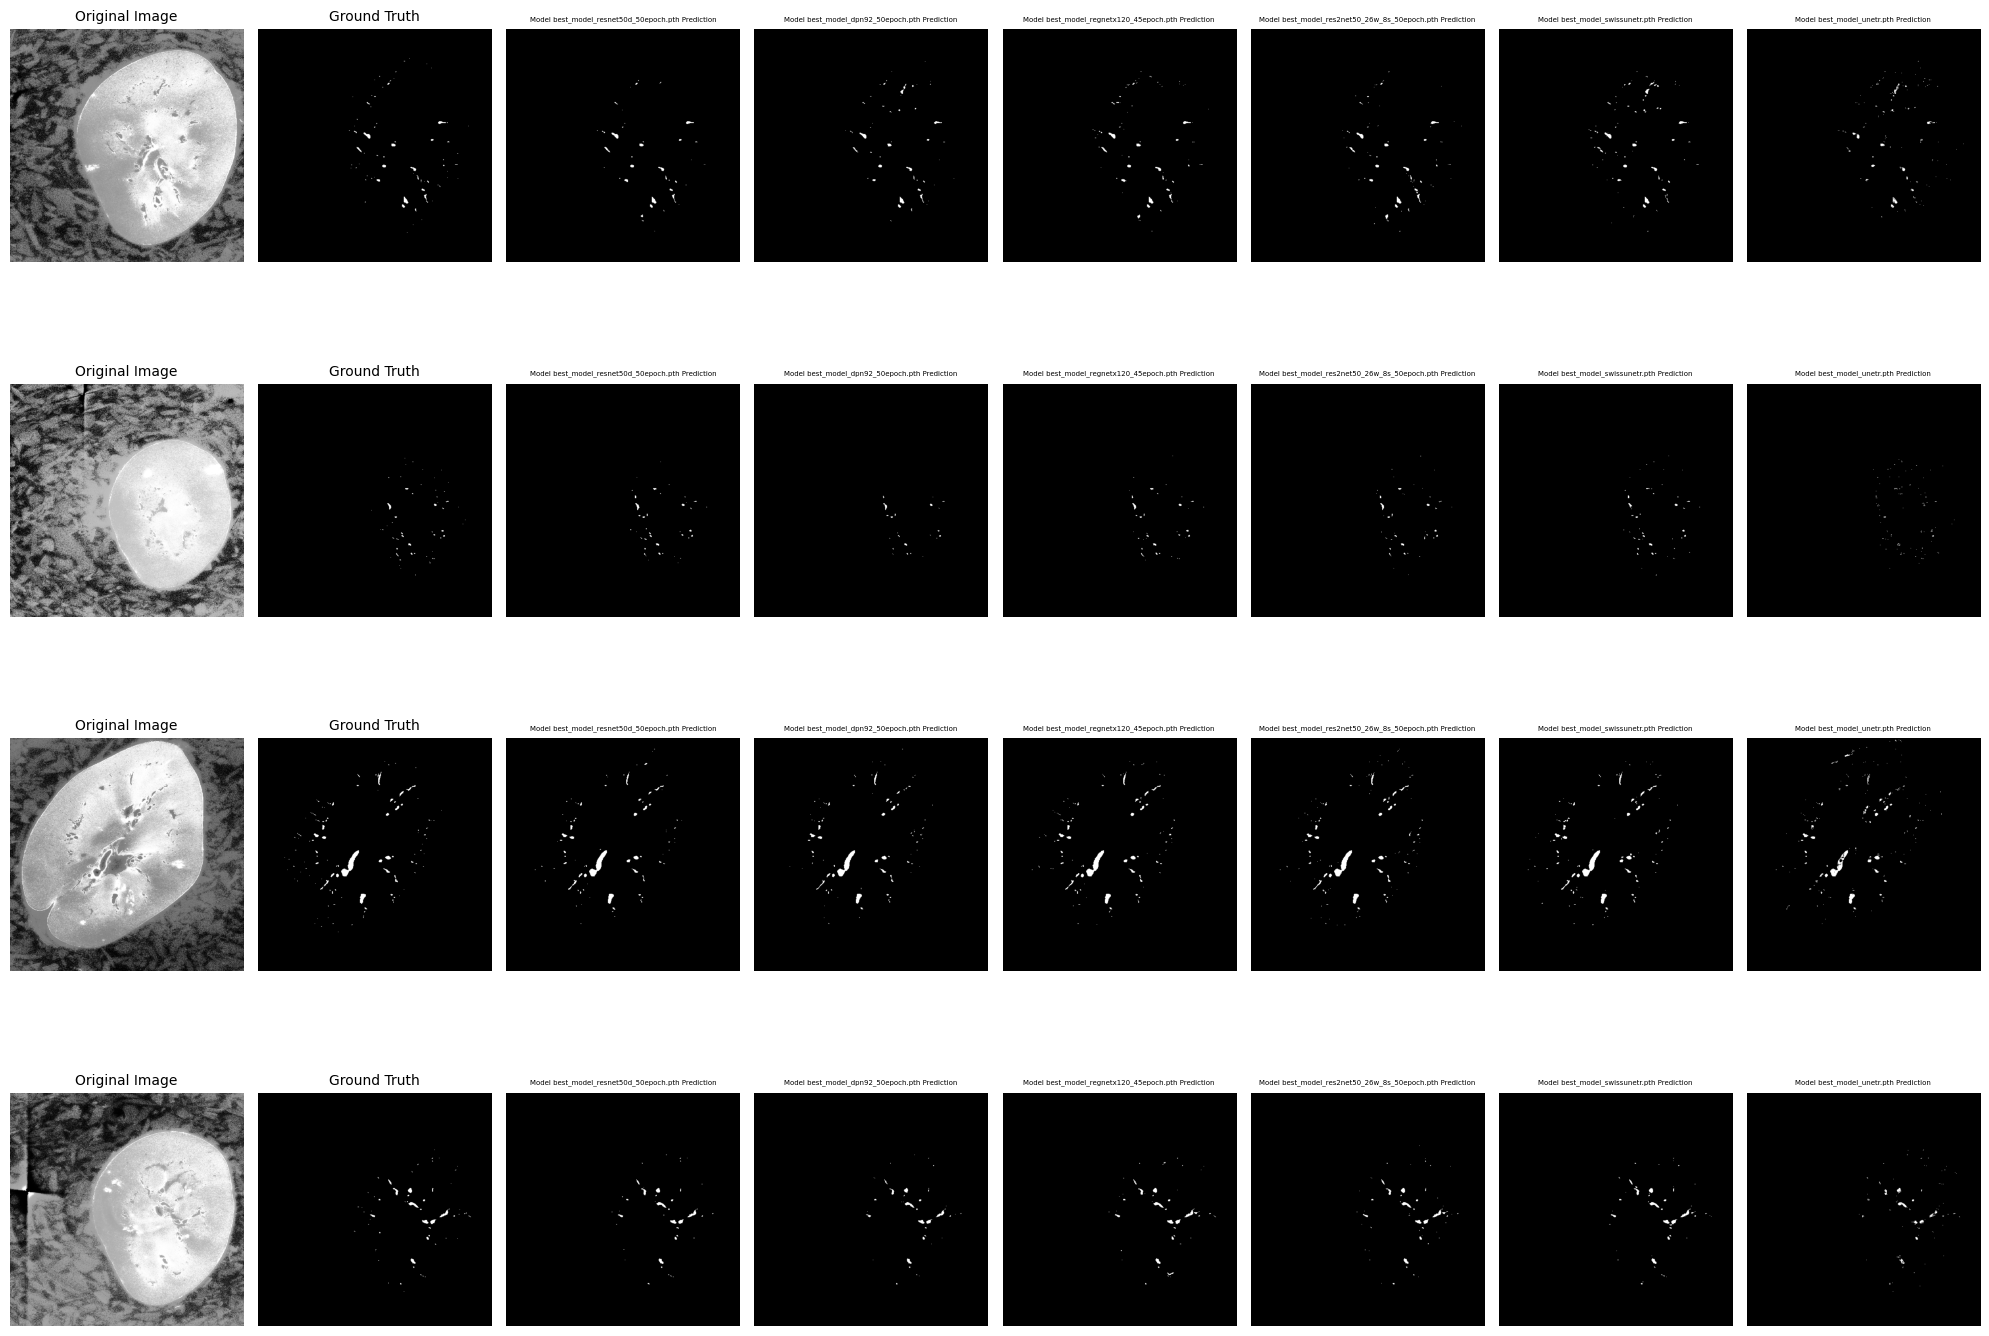

In [11]:
plot_model_comparisons(perfs, list(models.keys()))
